# ベイズ線形回帰 (Bayesian linear regression)

In [1]:
using Base: @kwdef
using Parameters: @unpack
using PyPlot, LinearAlgebra, Random, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
# Generate Toy datas
num_train, num_test = 20, 100 # sample size
dims = 4 # dimensions
σy = 0.3

polynomial_expansion(x; degree=3) = hcat([x .^ p for p in 0:degree]...);

Random.seed!(0);
x = rand(num_train)
y = sin.(2π*x) + σy * randn(num_train);
ϕ = polynomial_expansion(x, degree=dims-1) # design matrix

xtest = range(-0.1, 1.1, length=num_test)
ytest = sin.(2π*xtest)
ϕtest = polynomial_expansion(xtest, degree=dims-1);

conjugate prior

$$
p(\mathbf{w})=\mathcal{N}(\mathbf{w}|\boldsymbol{\mu}_0, \mathbf{\Sigma}_0)
$$

posterior

$$
p(\mathbf{w}|\mathbf{Y}, \mathbf{X})=\mathcal{N}(\mathbf{w}|\hat{\boldsymbol{\mu}}, \hat{\mathbf{\Sigma}})
$$

ただし，

$$
\begin{align}
\hat{\mathbf{\Sigma}}^{-1}&= \mathbf{\Sigma}_0^{-1}+ \beta \Phi^\top\Phi\\
\hat{\boldsymbol{\mu}}&=\Sigma_N (\mathbf{\Sigma}_0^{-1}\boldsymbol{\mu}_0+\beta \Phi^\top \mathbf{y})
\end{align}
$$

である．また，$\Phi=\phi.(\mathbf{x})$であり，$\phi(x)=[1, x, x^2, x^3]$, $\boldsymbol{\mu}_0=\mathbf{0}, \mathbf{\Sigma}_0= \alpha^{-1} \mathbf{I}$とする．

テストデータを$\mathbf{x}^*$とした際，予測分布は

$$
p(y^*|\mathbf{x}^*, \mathbf{Y}, \mathbf{X})=\mathcal{N}(y^*|\boldsymbol{\mu}^*, \mathbf{\Sigma}^*)
$$

となる．ただし，

$$
\begin{align}
\boldsymbol{\mu}^*&=\hat{\boldsymbol{\mu}}^\top \phi(\mathbf{x}^*)\\
\mathbf{\Sigma}^* &= \frac{1}{\beta} +  \phi(\mathbf{x}^*)^\top\hat{\mathbf{\Sigma}}\phi(\mathbf{x}^*)\\
\end{align}
$$

In [3]:
@kwdef mutable struct BayesianLinearReg
    μ̂::Array
    Σ̂::Array
end

# Training params & definition of model
function BayesianLinearReg(ϕ, y, α, β)
    Σ̂ = inv(α * I + β * ϕ' * ϕ)
    μ̂ = β * Σ̂  * ϕ' * y;
    return BayesianLinearReg(μ̂=μ̂, Σ̂=Σ̂)
end;

function predict(ϕ, blr::BayesianLinearReg, β)
    @unpack μ̂, Σ̂ = blr
    μp = ϕ * μ̂
    σp = sqrt.(1/β .+ diag(ϕ * Σ̂ * ϕ'));
    return μp, σp
end;

function sampling_func(ϕ, blr::BayesianLinearReg, num_sampling::Int)
    @unpack μ̂, Σ̂ = blr
    dist = MvNormal(μ̂, Matrix(Hermitian(Σ̂)))
    sampled_params = rand(dist, num_sampling);
    return ϕ * sampled_params 
end;

In [4]:
α, β = 1e-3, 5.0;

blr = BayesianLinearReg(ϕ, y, α, β);
μtest, σtest = predict(ϕtest, blr, β);

num_sampling = 5
sampled_func = sampling_func(ϕtest, blr, num_sampling);

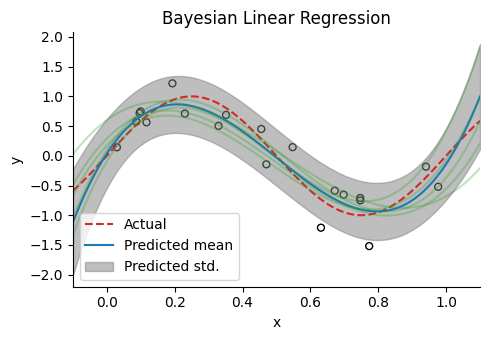

In [5]:
figure(figsize=(5,3.5))
title("Bayesian Linear Regression")
scatter(x, y, facecolor="None", edgecolors="black", s=25) # samples
plot(xtest, ytest, "--", label="Actual", color="tab:red")  # regression line
plot(xtest, μtest, label="Predicted mean", color="tab:blue")  # regression line
fill_between(xtest, μtest+σtest, μtest-σtest, alpha=0.5, color="tab:gray", label="Predicted std.")
for i in 1:num_sampling
    plot(xtest, sampled_func[:, i], alpha=0.3, color="tab:green")
end
xlabel("x"); ylabel("y"); legend()
xlim(-0.1, 1.1); tight_layout()

## MCMC

In [16]:
using ForwardDiff

In [17]:
function leapfrog(grad::Function, θ::Vector{Float64}, p::Vector{Float64}, ϵ::Float64, L::Int)
    for l in 1:L
        p += 0.5 * ϵ * grad(θ)
        θ += ϵ * p
        p += 0.5 * ϵ * grad(θ)
    end
    return θ, p
end;

In [18]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function HMC(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, L::Int, M::Int)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, M)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:M
        p = randn(d) # get momentum        
        H = -log_p(θ) + 0.5 * p' * p        # initial Hamiltonian
        θ_, p_ = leapfrog(grad, θ, p, ϵ, L) # update
        H_ = -log_p(θ_) + 0.5 * p_' * p_    # final Hamiltonian
        
        if min(1, exp(H - H_)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

In [12]:
log_joint(w, ϕ, y, σy, μ₀, Σ₀) = sum(logpdf.(Normal.(ϕ * w, σy), y)) + logpdf(MvNormal(μ₀, Σ₀), w);

In [6]:
w = randn(dims)
μ₀ = zeros(dims)
Σ₀ = 1/α * I;

In [14]:
ulp(w) = log_joint(w, ϕ, y, σy, μ₀, Σ₀)

ulp (generic function with 1 method)

In [15]:
ulp(w)

-132.47706834160664

In [7]:
logpdf(MvNormal(μ₀, Σ₀), w)

-17.492340442107146

In [21]:
w_init = rand(MvNormal(μ₀, Σ₀), 1)[:, 1]

4-element Vector{Float64}:
 -28.147261610685185
 -12.810864586329526
 -14.527256303090217
  29.142156893036045

In [22]:
samples, num_accepted = HMC(ulp, w_init, 1e-2, 10, 500)

([-0.5023212590722252 -4.2733285281611355 … 0.7149917536009668 0.7606120794790094; -0.6591368407358618 -4.474269290574865 … 4.248308046320677 4.325933442725914; -6.76605670809218 -10.149358497410716 … -20.31862517613532 -20.380803632047183; 34.569581528192174 31.63021377045974 … 15.391463741947884 15.373946885840322], 499)

In [23]:
size(samples)

(4, 500)

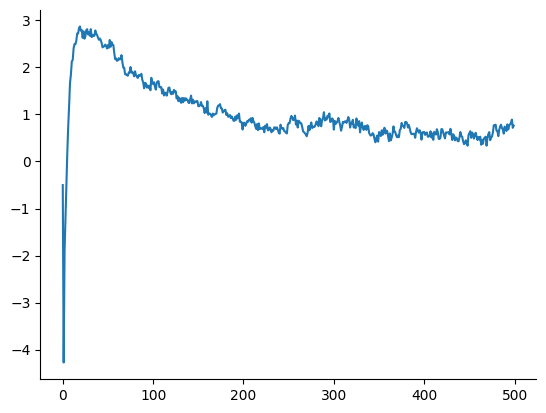

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000000F00550>

In [24]:
plot(samples[1, :])

In [26]:
hmc = ϕtest * samples[:, end];

In [47]:
size(samples[:, 496:end])

(4, 5)

In [54]:
yhmc = ϕtest * samples[:, 300:end];

In [33]:
size(yhmc)

(100, 50)

In [55]:
yhmc_mean = mean(yhmc, dims=2)[:];

In [56]:
yhmc_std = std(yhmc, dims=2)[:];

In [51]:
size(yhmc_mean)

(100,)

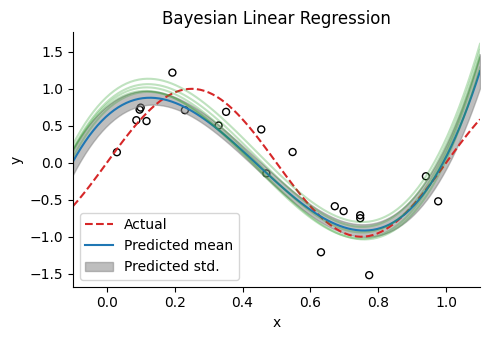

In [58]:
figure(figsize=(5,3.5))
title("Bayesian Linear Regression")
scatter(x, y, facecolor="None", edgecolors="black", s=25) # samples
plot(xtest, ytest, "--", label="Actual", color="tab:red")  # regression line
plot(xtest, yhmc_mean, label="Predicted mean", color="tab:blue")  # regression line
fill_between(xtest, yhmc_mean+yhmc_std, yhmc_mean-yhmc_std, alpha=0.5, color="tab:gray", label="Predicted std.")
for i in 1:5
    plot(xtest, yhmc[:, end-i], alpha=0.3, color="tab:green")
end
xlabel("x"); ylabel("y"); legend()
xlim(-0.1, 1.1); tight_layout()